In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score


In [2]:
from sentence_transformers import SentenceTransformer

# Проверяем, загружается ли BERT
model_bert = SentenceTransformer('all-MiniLM-L6-v2')
print("BERT загружен успешно!")

BERT загружен успешно!


In [3]:
# Загрузка данных из CSV файлов
cryptopanic_news = pd.read_csv(r'data/news/cryptopanic_news.csv')
currency = pd.read_csv(r'data/newscurrency.csv')
news_currency = pd.read_csv(r'data/news/news__currency.csv')
source = pd.read_csv(r'data/news/source.csv')

df_BTC_USDT = pd.read_csv(r"data/BTC_USDT_USDT_1h_ohlcv.csv")
df_ETH_USDT = pd.read_csv(r"data/ETH_USDT_USDT_1h_ohlcv.csv")
df_SOL_USDT = pd.read_csv(r"data/SOL_USDT_USDT_1h_ohlcv.csv")

In [4]:
df_BTC_USDT['code'] = 'BTC'
df_ETH_USDT['code'] = 'ETH'
df_SOL_USDT['code'] = 'SOL'

df_price  = pd.concat([df_BTC_USDT, df_ETH_USDT, df_SOL_USDT ], ignore_index=True)

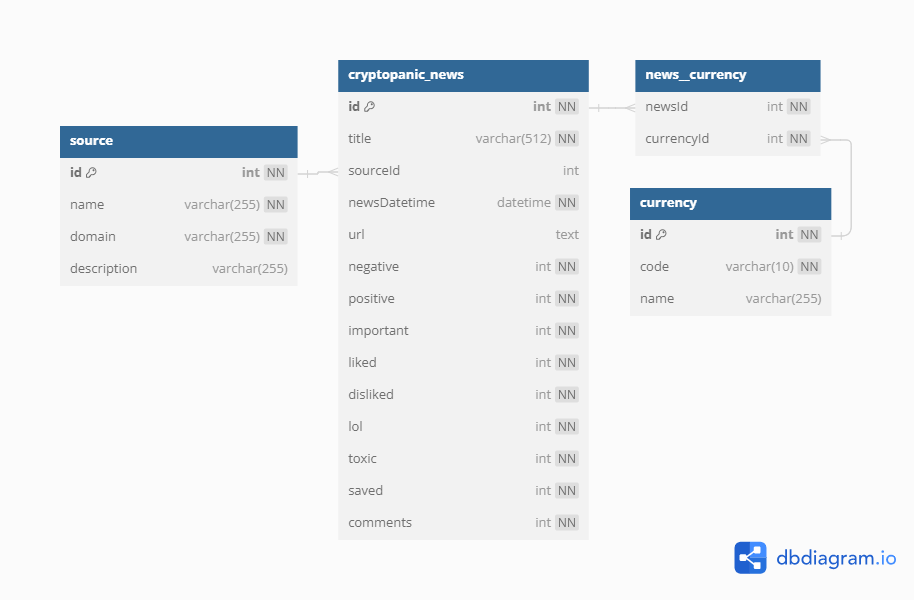

In [5]:
# Выполнение соединений
df_news = cryptopanic_news.merge(news_currency, left_on='id', right_on='newsId') \
                              .merge(currency, left_on='currencyId', right_on='id') \
#                               .merge(source, left_on='sourceId', right_on='id') 



# Примерные названия столбцов
df_news["newsDatetime"] = pd.to_datetime(df_news["newsDatetime"])  # Дата новости
df_price["timestamp"] = pd.to_datetime(df_price["timestamp"])  # Временная метка цены

# Сортируем по времени (обязательно для merge_asof)
df_news = df_news.sort_values("newsDatetime")
df_price = df_price.sort_values("timestamp")

# Джойним по времени с учетом "code"
df_1 = pd.merge_asof(
    df_news, df_price, 
    left_on="newsDatetime", 
    right_on="timestamp", 
    by="code"  # Объединяем только строки с одинаковым кодом валюты
)

df_2 = df_1[~df_1['open'].isna()]
len(df_1), len(df_2)

(277481, 41091)

### create target

In [6]:
N = 6  # Горизонт прогноза

# Делаем копию цен и сдвигаем время вперёд на N часов
df_price_shifted = df_2[["code", "timestamp", "close"]].copy()
df_price_shifted["timestamp"] += pd.Timedelta(hours=N)

# Джойним с `df_2`, чтобы добавить цену через N часов
df_2 = pd.merge_asof(
    df_2.sort_values("newsDatetime"), 
    df_price_shifted.sort_values("timestamp"), 
    left_on="newsDatetime", 
    right_on="timestamp", 
    by="code", 
    suffixes=("", f"_t{N}")  
)

# Создаём бинарный таргет: 1 = цена выросла, 0 = цена упала
df_2[f"target_{N}h_binary"] = (df_2[f"close_t{N}"] > df_2["close"]).astype(int)

df_2[[f"target_{N}h_binary", "newsDatetime", "close", f"close_t{N}"]].head(3)

,target_6h_binary,newsDatetime,close,close_t6
0,0,2020-04-16 05:02:12,6632.80,NaN
1,0,2020-05-13 11:16:19,190.96,NaN
2,0,2020-05-14 23:06:34,203.31,190.96


In [7]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41091 entries, 0 to 41090
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_x              41091 non-null  int64         
 1   title             41091 non-null  object        
 2   sourceId          41091 non-null  int64         
 3   newsDatetime      41091 non-null  datetime64[ns]
 4   url               41091 non-null  object        
 5   negative          41091 non-null  int64         
 6   positive          41091 non-null  int64         
 7   important         41091 non-null  int64         
 8   liked             41091 non-null  int64         
 9   disliked          41091 non-null  int64         
 10  lol               41091 non-null  int64         
 11  toxic             41091 non-null  int64         
 12  saved             41091 non-null  int64         
 13  comments          41091 non-null  int64         
 14  newsId            4109

In [8]:
df_2 = df_2.fillna(0)

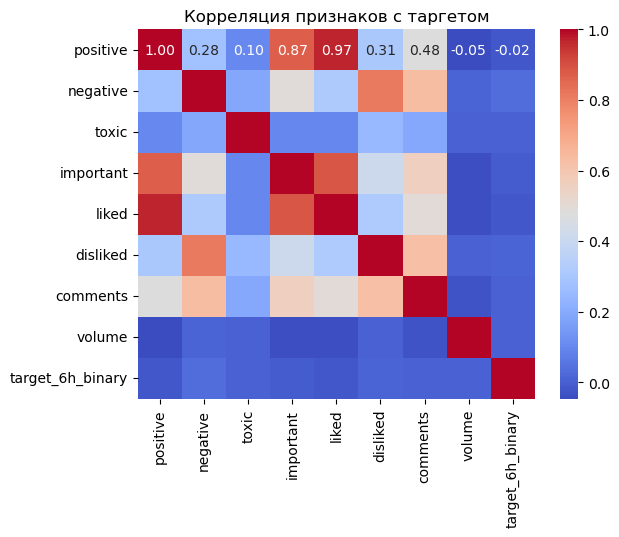

In [11]:
corr_matrix = df_2[['positive', 'negative', 'toxic', 'important', 'liked',
                    'disliked', 'comments', 'volume', 'target_6h_binary']].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляция признаков с таргетом')
plt.show()

In [12]:
corr_matrix['target_6h_binary'].sort_values(ascending=False)

target_6h_binary    1.000000
negative            0.032622
disliked            0.012365
volume              0.004785
comments            0.004583
toxic               0.004465
important          -0.008983
liked              -0.021429
positive           -0.022307
Name: target_6h_binary, dtype: float64

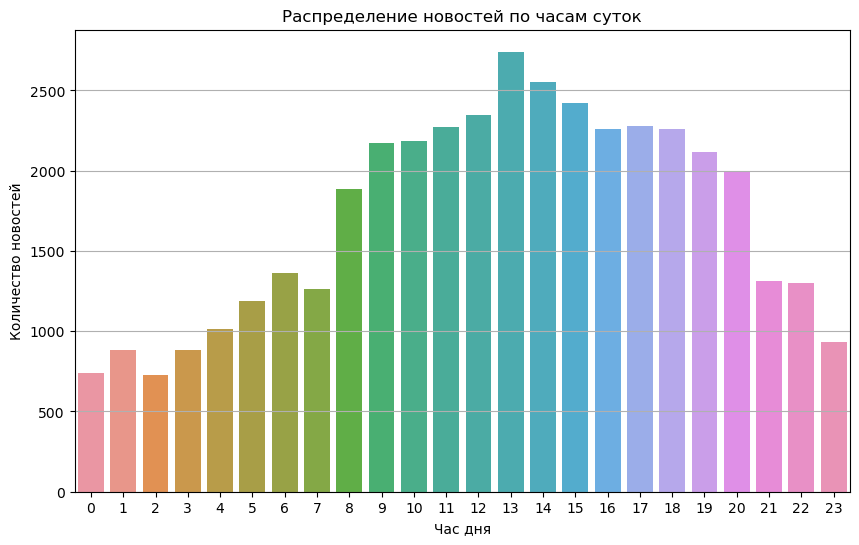

In [13]:
# Распределение по часам
plt.figure(figsize=(10, 6))
sns.countplot(x=df_2['newsDatetime'].dt.hour)
plt.title('Распределение новостей по часам суток')
plt.xlabel('Час дня')
plt.ylabel('Количество новостей')
plt.xticks(range(0, 24))
plt.grid(axis='y')
plt.show()

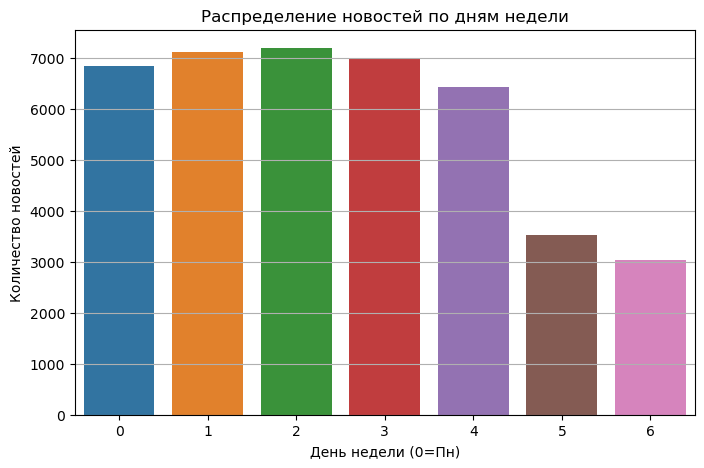

In [14]:
# День недели: 0 - Пн, 6 - Вс
plt.figure(figsize=(8, 5))
sns.countplot(x=df_2['newsDatetime'].dt.weekday)
plt.title('Распределение новостей по дням недели')
plt.xlabel('День недели (0=Пн)')
plt.ylabel('Количество новостей')
plt.grid(axis='y')
plt.show()

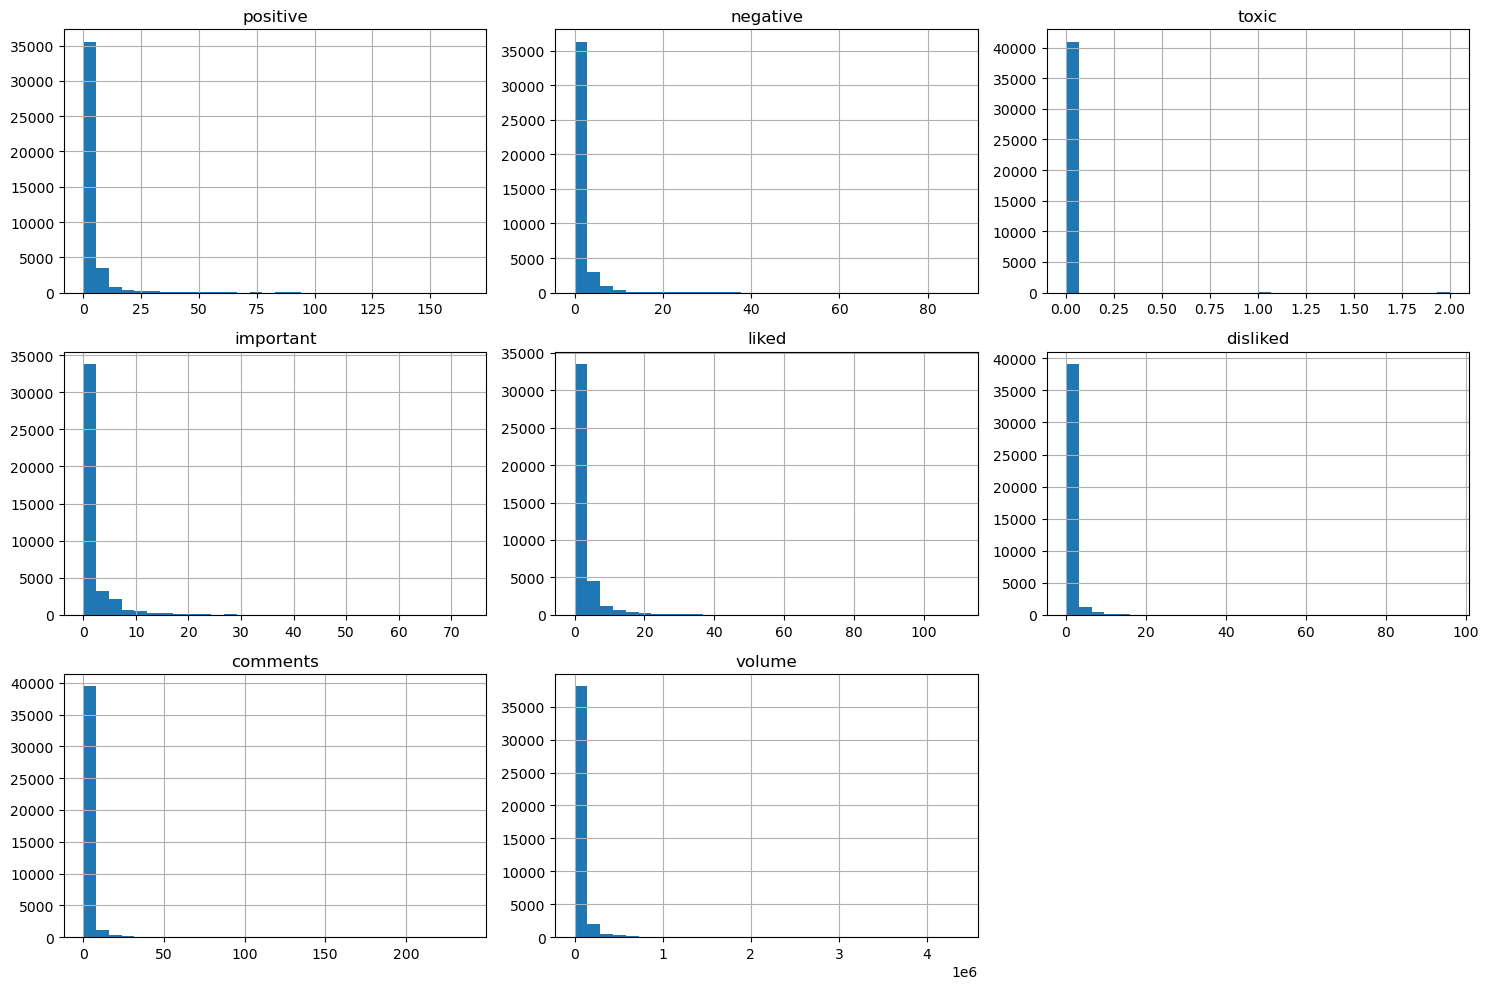

In [15]:
num_features = ["positive", "negative", "toxic", "important", "liked", "disliked", "comments", "volume"]
df_2[num_features].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [16]:
class_counts = df_2['target_6h_binary'].value_counts()
print("Количество объектов по классам:\n", class_counts)

class_percent = df_2['target_6h_binary'].value_counts(normalize=True) * 100
print("\nПроцентное распределение классов:\n", class_percent.round(2))

Количество объектов по классам:
 target_6h_binary
0    20688
1    20403
Name: count, dtype: int64

Процентное распределение классов:
 target_6h_binary
0    50.35
1    49.65
Name: proportion, dtype: float64


In [21]:
N = 6  # Горизонт прогноза

# Выбираем фичи для модели
features = [
    "positive", "negative", "toxic", "important", "liked", 
    "disliked", "comments", "sourceId"
]

# Преобразуем время публикации в дополнительные признаки
df_2["hour"] = df_2["newsDatetime"].dt.hour  # Час дня
df_2["weekday"] = df_2["newsDatetime"].dt.weekday  # День недели (0=Пн, 6=Вс)
features += ["hour", "weekday"]

# Преобразуем текст заголовков в TF-IDF
vectorizer = TfidfVectorizer(max_features=500)
X_text = vectorizer.fit_transform(df_2["title"].fillna(""))

# Собираем финальный массив признаков
X_numeric = df_2[features].fillna(0)
X = np.hstack((X_numeric, X_text.toarray()))
y = df_2[f"target_{N}h_binary"]

# Разбиваем на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем CatBoost
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=100)
model.fit(X_train, y_train)

# Получаем предсказания классов и вероятностей
y_pred = model.predict(X_test)                # ← классы 0 или 1
y_pred_proba = model.predict_proba(X_test)[:, 1]  # ← вероятности класса 1

# Считаем метрики
precision = precision_score(y_test, y_pred)
accuracy = model.score(X_test, y_test)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {auc:.4f}")

0:	learn: 0.6927328	total: 55.8ms	remaining: 27.8s
100:	learn: 0.6769750	total: 4.49s	remaining: 17.7s
200:	learn: 0.6567119	total: 8.95s	remaining: 13.3s
300:	learn: 0.6392455	total: 13.4s	remaining: 8.86s
400:	learn: 0.6232008	total: 17.8s	remaining: 4.41s
499:	learn: 0.6078434	total: 22.2s	remaining: 0us
Accuracy: 0.5667
Precision: 0.5659
Recall: 0.5380
ROC AUC: 0.5935


In [22]:
# Получаем значимость
importances = model.get_feature_importance()
feature_names = features + list(vectorizer.get_feature_names_out())

# Создаём таблицу
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Покажем топ-20
print(importance_df.head(20))

      Feature  Importance
8        hour    6.461804
9     weekday    4.163403
7    sourceId    3.520527
96    bitcoin    2.424731
1    negative    2.411712
0    positive    2.039271
4       liked    1.692626
179  ethereum    1.656906
443        to    1.640489
240        in    1.540591
140    crypto    1.436136
63        and    1.304945
351     price    1.115177
407    solana    1.087031
196       for    1.023666
436       the    1.004048
71         as    0.974883
325        on    0.911950
90      below    0.885604
323        of    0.844770


In [24]:

# Преобразуем время публикации в дополнительные признаки
df_2["hour"] = df_2["newsDatetime"].dt.hour  # Час дня
df_2["weekday"] = df_2["newsDatetime"].dt.weekday  # День недели (0=Пн, 6=Вс)
df_2["title_length"] = df_2["title"].apply(lambda x: len(str(x)))
df_2["is_night"] = df_2["hour"].apply(lambda x: 1 if x < 6 else 0)
df_2["is_weekend"] = df_2["weekday"].apply(lambda x: 1 if x >= 5 else 0)

# Добавляем новые признаки в список
features += ["is_night", "is_weekend", "hour", "weekday", "title_length"]

# Преобразуем время публикации в дополнительные признаки
df_2["hour"] = df_2["newsDatetime"].dt.hour  # Час дня
df_2["weekday"] = df_2["newsDatetime"].dt.weekday  # День недели (0=Пн, 6=Вс)
features += ["hour", "weekday"]

# Преобразуем текст заголовков в TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(df_2["title"].fillna(""))

# Собираем финальный массив признаков
X_numeric = df_2[features].fillna(0)
X = np.hstack((X_numeric, X_text.toarray()))
y = df_2[f"target_{N}h_binary"]

# Разбиваем на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем CatBoost
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=100)
model.fit(X_train, y_train)


# Получаем предсказания классов и вероятностей
y_pred = model.predict(X_test)                # ← классы 0 или 1
y_pred_proba = model.predict_proba(X_test)[:, 1]  # ← вероятности класса 1

# Считаем метрики
precision = precision_score(y_test, y_pred)
accuracy = model.score(X_test, y_test)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Вывод
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {auc:.4f}")

0:	learn: 0.6926236	total: 61ms	remaining: 30.5s
100:	learn: 0.6750809	total: 5.82s	remaining: 23s
200:	learn: 0.6559619	total: 11.6s	remaining: 17.2s
300:	learn: 0.6384729	total: 17.4s	remaining: 11.5s
400:	learn: 0.6223199	total: 23.1s	remaining: 5.71s
499:	learn: 0.6080791	total: 28.8s	remaining: 0us
Accuracy: 0.5658
Precision: 0.5651
Recall: 0.5352
ROC AUC: 0.5946


In [25]:
# Горизонт прогноза
N = 6  


# === Преобразуем заголовки в эмбеддинги BERT ===
print("Создание эмбеддингов BERT для заголовков...")
model_bert = SentenceTransformer('all-MiniLM-L6-v2', device="cpu")  # Если есть GPU, замени "cpu" на "cuda"
X_text_bert = model_bert.encode(df_2["title"].fillna(""), show_progress_bar=True)

# Собираем финальный массив признаков
X_numeric = df_2[features].fillna(0).to_numpy()  # Числовые фичи
X = np.hstack((X_numeric, X_text_bert))  # Объединяем всё
y = df_2[f"target_{N}h_binary"]

# Разбиваем на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем CatBoost
print("Обучение модели...")
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=100)
model.fit(X_train, y_train)

# Получаем предсказания классов и вероятностей
y_pred = model.predict(X_test)                # ← классы 0 или 1
y_pred_proba = model.predict_proba(X_test)[:, 1]  # ← вероятности класса 1

# Считаем метрики
precision = precision_score(y_test, y_pred)
accuracy = model.score(X_test, y_test)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Вывод
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {auc:.4f}")

Создание эмбеддингов BERT для заголовков...


Batches:   0%|          | 0/1285 [00:00<?, ?it/s]

Обучение модели...
0:	learn: 0.6924466	total: 105ms	remaining: 52.4s
100:	learn: 0.6532824	total: 5.01s	remaining: 19.8s
200:	learn: 0.6058182	total: 9.91s	remaining: 14.7s
300:	learn: 0.5635756	total: 15s	remaining: 9.89s
400:	learn: 0.5265791	total: 20.2s	remaining: 4.98s
499:	learn: 0.4931685	total: 25.2s	remaining: 0us
Accuracy: 0.5918
Precision: 0.5922
Recall: 0.5647
ROC AUC: 0.6313


In [26]:
MODEL_PATH = "catboost_news_model2.pkl"
joblib.dump(model, MODEL_PATH)

['catboost_news_model2.pkl']

### Код пайплайна

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from catboost import CatBoostClassifier
from torch import cuda
import joblib  # Для сохранения модели

# === Глобальные настройки ===
N = 6  # Горизонт прогноза (через сколько часов проверяем рост цены)
BATCH_SIZE = 32  # Размер батча для BERT
MODEL_PATH = "catboost_news_model.pkl"  # Файл для сохранения модели
BERT_MODEL_NAME = "paraphrase-MiniLM-L3-v2"  # Лёгкая версия BERT

# === 1. Функция предобработки данных ===
def preprocess_data(df, is_training=True):
    """Формирует признаки и кодирует текст BERT'ом"""
    print(" Предобработка данных...")

    # Создаём признаки времени
    df["hour"] = df["newsDatetime"].dt.hour
    df["weekday"] = df["newsDatetime"].dt.weekday
    df["title_length"] = df["title"].apply(lambda x: len(str(x)))
    df["is_night"] = df["hour"].apply(lambda x: 1 if x < 6 else 0)
    df["is_weekend"] = df["weekday"].apply(lambda x: 1 if x >= 5 else 0)

    # Новостной фон (средняя тональность за 6 часов)
    df = df.sort_values("newsDatetime")
    df["avg_positive_6h"] = df.groupby("code")["positive"].transform(lambda x: x.rolling("6h").mean())
    df["avg_negative_6h"] = df.groupby("code")["negative"].transform(lambda x: x.rolling("6h").mean())

    # Изменение цены перед новостью
    df["price_change_6h"] = df.groupby("code")["close"].pct_change(periods=6)

    # Выбираем признаки
    features = [
        "positive", "negative", "toxic", "important", "liked", "disliked", "comments", "sourceId",
        "is_night", "is_weekend", "hour", "weekday", "title_length",
        "avg_positive_6h", "avg_negative_6h", "price_change_6h"
    ]

    # Устройство для BERT
    device = "cuda" if cuda.is_available() else "cpu"

    # Загружаем BERT и кодируем заголовки
    print(f"Кодирование заголовков BERT ({BERT_MODEL_NAME})...")
    model_bert = SentenceTransformer(BERT_MODEL_NAME, device=device)
    X_text_bert = model_bert.encode(df["title"].fillna("").tolist(), batch_size=BATCH_SIZE, show_progress_bar=True)

    # Объединяем числовые признаки и эмбеддинги BERT
    X_numeric = df[features].fillna(0).to_numpy()
    X = np.hstack((X_numeric, X_text_bert))

    # Если это обучение, возвращаем и таргет
    if is_training:
        y = df[f"target_{N}h_binary"]
        return X, y
    return X

# === 2. Функция обучения модели ===
def train_model(df):
    """Обучает CatBoost и сохраняет модель"""
    print(" Обучение модели...")
    
    # Готовим данные
    X, y = preprocess_data(df)

    # Разбиваем на train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучаем CatBoost
    model = CatBoostClassifier(iterations=1000, depth=8, learning_rate=0.05, l2_leaf_reg=3, verbose=100)
    model.fit(X_train, y_train)

    # Оцениваем точность
    accuracy = model.score(X_test, y_test)
    print(f" Точность модели: {accuracy:.4f}")

    # Сохраняем модель
    joblib.dump(model, MODEL_PATH)
    print(f" Модель сохранена в {MODEL_PATH}")

# === 3. Функция предсказания на новых новостях ===
def predict_new_news(df_new):
    """Делает предсказание для новых новостей"""
    print(" Предсказание новых новостей...")

    # Загружаем обученную модель
    model = joblib.load(MODEL_PATH)

    # Обрабатываем новые данные
    X_new = preprocess_data(df_new, is_training=False)

    # Предсказываем
    predictions = model.predict(X_new)
    df_new["prediction"] = predictions

    # Выводим первые 5 результатов
    print(df_new[["newsDatetime", "title", "prediction"]].head())
    return df_new


# Пайплайн прогнозирования влияния новостей на цену криптовалют

## Описание
Этот пайплайн анализирует новости и предсказывает, **вызовет ли новость рост цены через N часов**.  
Модель использует **эмбеддинги BERT** для обработки заголовков и **CatBoost** для предсказаний.  

## Входные данные

### 1. Исторические данные (`historical_news_data.csv`)
Этот файл используется для **обучения** модели.  

🔹 **Обязательные колонки:**
| Колонка         | Описание |
|----------------|----------|
| `id_x`        | ID новости |
| `title`       | Заголовок новости |
| `sourceId`    | Источник (ID) |
| `newsDatetime`| Дата и время публикации новости (`YYYY-MM-DD HH:MM:SS`) |
| `positive`    | Позитивная тональность (0-1) |
| `negative`    | Негативная тональность (0-1) |
| `toxic`       | Токсичность (0-1) |
| `important`   | Важность (0-1) |
| `liked`       | Количество лайков |
| `disliked`    | Количество дизлайков |
| `comments`    | Количество комментариев |
| `code`        | Символ криптовалюты (`BTC`, `ETH`, ...) |
| `timestamp`   | Время свечи цены (`YYYY-MM-DD HH:MM:SS`) |
| `open`        | Цена открытия свечи |
| `high`        | Максимальная цена |
| `low`         | Минимальная цена |
| `close`       | Цена закрытия свечи |
| `volume`      | Объём торгов |
| `target_6h_binary` | Целевой таргет (`1` - цена выросла через 6 часов, `0` - упала) |

 **Как получить `target_6h_binary`?**  
Если данных нет, его можно создать автоматически перед обучением.

---

### 2. Новые новости (`new_news_data.csv`)
Этот файл содержит **новые новости**, на которых модель будет делать предсказания.  
🔹 **Обязательные колонки (как в обучении, но без `target_6h_binary`)**  
После обработки добавится колонка **`prediction`** (`1` - цена вырастет, `0` - упадёт).  

---

## Установка зависимостей
Перед запуском убедитесь, что установлены все библиотеки:
```bash
pip install pandas numpy sentence-transformers catboost torch joblib

# Входные данные для предсказания модели

## Что подаётся на вход обученной модели?
После предобработки модель получает **вектор признаков**, включающий:
1. **Числовые признаки (новостные и рыночные)**
2. **Эмбеддинги заголовков, созданные с помощью BERT**

---

## Структура входных данных

### Входной DataFrame перед подачей в модель
Перед тем как модель делает предсказание, каждая строка данных выглядит так:

| Колонка            | Описание |
|--------------------|----------|
| `positive`        | Доля позитивной тональности (0-1) |
| `negative`        | Доля негативной тональности (0-1) |
| `toxic`          | Доля токсичности (0-1) |
| `important`      | Важность новости (0-1) |
| `liked`          | Количество лайков |
| `disliked`       | Количество дизлайков |
| `comments`       | Количество комментариев |
| `sourceId`       | ID источника новости |
| `is_night`       | Опубликована ночью (`1` если <6 утра, иначе `0`) |
| `is_weekend`     | Опубликована в выходные (`1` если Сб/Вс, иначе `0`) |
| `hour`           | Час публикации новости (0-23) |
| `weekday`        | День недели (0=Пн, 6=Вс) |
| `title_length`   | Количество символов в заголовке |
| `avg_positive_6h` | Средняя позитивность новостей за 6 часов |
| `avg_negative_6h` | Средняя негативность новостей за 6 часов |
| `price_change_6h` | Изменение цены за последние 6 часов (`(close_now - close_6h) / close_6h`) |
| **`bert_0 ... bert_383`** | Вектор размером `384` из эмбеддинга заголовка |

---

## Как выглядят данные после обработки?
Пример одной строки, которая подаётся в модель: